# Binary XGBoost models to predict whether a patient is at least as well as mRS0, mRS1, mRS2. mRS3. mRS4 and mRS5.

### Plain English summary

To look at the interaction of feature Year with Stroke team (as year is only selected in the feature list if stroke team an option too).

SHAP interactions can not be calculated for multiclass classification. Instead train binary models, converting the target feature (disability_discharge) into a binary feature by predicting one class vs the rest. Have seven models (predict mRS0 vs mRS1-6, predict mRS0-1 vs rest, predict mRS0-2 vs rest, predict mRS0-3 vs rest, predict mRS0-4 vs rest, predict mRS0-5 vs rest)  

Use just first kfold as seen performance of model is consistent across the 5 kfold splits.

Each binary model is trained using 7 features "prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known"]\

### Model and data

Set of 7 binary XGBoost classification models, predicting whether a single mRS level, or not.\
7 features: ["prior_disability", "stroke_severity", "stroke_team", "age", "onset-to-thrombolysis-time", "any_afib_diagnosis", "precise_onset_known"]\
First k-fold\

### Aims


### Observations




#### Further work

#### Resources
Using code from https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/02b_xgb_combined_fit_accuracy_key_features_separate_k_fold.ipynb

and https://github.com/samuel-book/samuel_shap_paper_1/blob/main/xgb_10_features/03_xgb_combined_shap_key_features.ipynb




## Import libraries

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd

import scipy

from xgboost import XGBClassifier
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

import json

from dataclasses import dataclass

from sklearn.metrics import roc_auc_score

from sklearn.metrics import confusion_matrix

import pickle
import shap

from os.path import exists

import math

import copy

import time
import datetime

Report the time duration to run notebook

In [2]:
start_time = time.time()

Use just the first k-fold split

In [3]:
k = 0

# Values to use as the threshold <= n in order to divide the target feature
list_binary_thresholds = [0, 1, 2, 3, 4, 5]

n_binary_models = len(list_binary_thresholds)

Select the features for the model

In [4]:
selected_features = ["prior_disability", "stroke_severity", "stroke_team", 
                     "age", "any_afib_diagnosis", 
                     "onset_to_thrombolysis_time", "precise_onset_known", 
                     "year"]
n_features = len(selected_features)

target_feature = 'discharge_disability'

## Set up paths and filenames

Use os.path.join() to create filenames. So define folders without trailing forward slash, and include all characters in file names.

In [5]:
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''
    image_save_path: str = './saved_images'
    model_save_path: str = './saved_models'
    data_save_path: str = './saved_data'
    data_read_path: str = '../data_processing/output/kfold_5fold'
    model_text: str = (f'xgb_{n_features}_features_1kfold'
                       f'_binary')
    notebook: str = '080_'

paths = Paths()

Create output folders if needed

In [6]:
path = paths.image_save_path
if not os.path.exists(path):
    os.makedirs(path)
        
path = paths.model_save_path
if not os.path.exists(path):
    os.makedirs(path)

path = paths.data_save_path
if not os.path.exists(path):
    os.makedirs(path)

## Import data

Import the data for the first kfold split.

Extract the features for the model.

In [7]:
filename = os.path.join(paths.data_read_path, ('03_train_' + str(k) + '.csv'))
train_data = pd.read_csv(filename)
X_train = train_data[selected_features]
y_train = train_data[target_feature]

filename = os.path.join(paths.data_read_path, ('03_test_' + str(k) + '.csv'))
test_data = pd.read_csv(filename)
X_test = test_data[selected_features]
y_test = test_data[target_feature]

### One hot the categorical features

Convert some categorical features to one hot encoded features.

Define a function

In [8]:
def convert_feature_to_one_hot(df, feature_name, prefix):
    """
    Converts a categorical feature into a one hot encoded feature
    
    Args:
        df [dataframe]: training or test dataset
        feature_name [str]: feature to convert to one hot encoding
        prefix [str]: string to use on new feature

    Return:
        df [dataframe]: One hot encoded representation of the feature
    """

    # One hot encode a feature
    df_feature = pd.get_dummies(
        df[feature_name], prefix=prefix)
    df = pd.concat([df, df_feature], axis=1)
    df.drop(feature_name, axis=1, inplace=True)

    return(df)

Keep copy of original data, with 'Stroke team' not one-hot encoded

In [9]:
test_stroke_team = X_test["stroke_team"].values
train_stroke_team = X_train["stroke_team"].values

For both train and test dataset, convert "stroke_team" feature to one hot encoded.

In [10]:
feature = "stroke_team"
prefix = "team"
if feature in list(X_train):
    X_train = convert_feature_to_one_hot(X_train, feature, prefix)
    X_test = convert_feature_to_one_hot(X_test, feature, prefix)

Feature names with one hot encoding

In [11]:
feature_names_ohe = list(X_train)
n_features_ohe = len(feature_names_ohe)

In [12]:
print(f"There are {len(selected_features)} original features "
      f"(before one-hot encoding)")
print(f"There are {n_features_ohe} features (after one-hot encoding)")

There are 8 original features (before one-hot encoding)
There are 125 features (after one-hot encoding)


Crate a dataframe containing each of the target features for the different threshold values

In [13]:
def create_df_of_binary_target_features(target_feature_data, binary_thresholds):
    """ 
    Given a feature, return a dataframe of all of the different binary versions 
    depending on the threshold used

    Args:
        data [dataframe]: patient feature values
        target_feature [string]: feature name of target feature
        binary_thresholds [list]: list of thresholds to use for each version of 
                    a binary target feature

    Return:
        df [dataframe]: row per instance, column per threshold. Containing 
        feature values for patients with binary representation of the target 
        feature, based on the threshold value 
    
    """    
    df = pd.DataFrame()

    for threshold in binary_thresholds:
        binary_target_feature_name = f'{target_feature}_bin_{threshold}'

        # For the new feature, set all to 0    
        df[binary_target_feature_name] = 0

        # Then set to 1 those patients that are the threshold value or less
        df[binary_target_feature_name] = (
                                    (target_feature_data <= threshold) * 1)
        
    return(df)

Create dataframe of the binary target features

In [14]:
df_all_y_bin_train = create_df_of_binary_target_features(y_train, list_binary_thresholds)
df_all_y_bin_test = create_df_of_binary_target_features(y_test, list_binary_thresholds)

Plot barchart of proportion in each class for each of the thresholds

In [15]:
def plot_barchart(df_bin_target_feature):
    """
    
    Args:
        df_bin_target_feature [dataframe]: A column per target feature using a 
                      different threshold for a binary representation 
        
    Return:
        None    
    """  
    
    count_0 = []
    count_1 = []
    max_accuracy_if_majority = []
    n_instances = df_bin_target_feature.shape[0]
    columns = df_bin_target_feature.columns

    for col in columns:
        df_bin_target_feature[col]
        n_zeros = (df_bin_target_feature[col] == 0).sum()
        count_0.append(n_zeros)
        n_ones = (df_bin_target_feature[col] == 1).sum()
        count_1.append(n_ones)

        # If model predicted every instance was the majority class, what would 
        # the accuracy be
        max_accuracy = max(n_zeros/n_instances, n_ones/n_instances)
        max_accuracy_if_majority.append(round(max_accuracy*100, 1))

    # create data
    x = np.arange(len(count_1)).tolist()

    x_ticks = []
    for i in x:
        x_ticks.append(f"{i}\n[{max_accuracy_if_majority[i]}%]") 

    # plot bars in stack manner
    plt.bar(x, count_1, bottom=count_0, color='b', label="Yes")
    plt.bar(x, count_0, color='r', label="No")
    plt.xlabel("mRS threshold for being 'at least as well as'\n[accuracy if "
               "all instances classified as majority class]")
    plt.ylabel("Count of patients")
    plt.xticks(x, x_ticks)
    plt.legend(bbox_to_anchor=(1.03, 1.0))
    plt.title("Count of patients in each binary category, for each threshold "
              "level (test dataset)")
    plt.show()
    return(max_accuracy_if_majority)

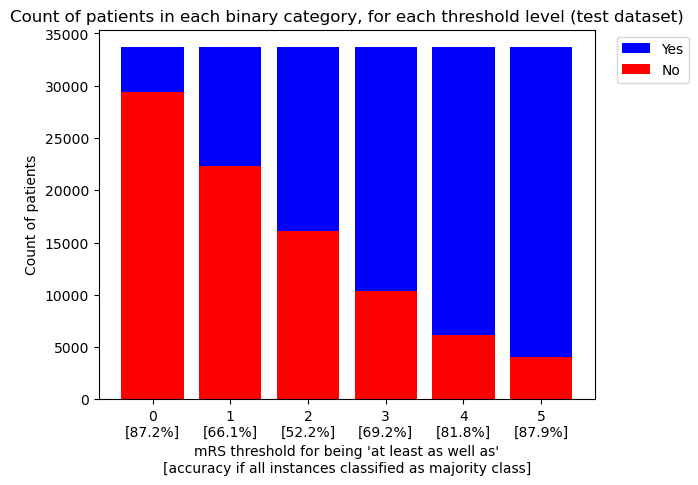

In [16]:
max_accuracy_if_majority = plot_barchart(df_all_y_bin_test)

Define function to fit XGBoost model

In [17]:
def fit_xgb_model(X_train, y_train, filename):
    """
    Given the filename, either load if the model exists (saved as a pickle), 
    else train a new model.

    Args:
        filename [string]: where xgboost model is saved
        X_train [dataframe]: feature values
        y_train [dataframe]: target feature
        
    Returns:
        model [object]: xgboost classifier model

    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
    # Load models
        with open(filename, 'rb') as filehandler:
            model = pickle.load(filehandler)
    else:
        # Define and Fit model
        model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5,
                                tree_method='gpu_hist')
        model.fit(X_train, y_train)

        with open(filename, 'wb') as filehandler:
            pickle.dump(model, filehandler)

    return(model)

Define function to calculate preditions from model

In [18]:
def calculate_predicted_probabilities(model, X_data):
    """ 
    Given a model and input data, return the models probability and prediction
    for each instance.
    
    Args:
        model [xgboost classifier object]: trained model
        X_data [dataframe]: input features for model

    Return:
        y_probs [array]: the probability of being in each target feature class
        y_pred [array]: the prediction (the class with the largest probability)
    """

    # Get and store predicted probabilities
    y_probs = model.predict_proba(X_data)

    # Get and store predicted class
    y_pred = model.predict(X_data)

    return(y_probs, y_pred)

TreeExplainer is a fast and exact method to estimate SHAP values for tree models and ensembles of trees. Using this we can calculate the SHAP values.

Either load SHAP extended from pickle (if file exists), or calculate.

Create function to return SHAP values extended

In [19]:
def calculate_shap_extended(filename, model, X_train, X_test):
    """
    TreeExplainer is a fast and exact method to estimate SHAP values for tree 
    models and ensembles of trees. Using this we can calculate the SHAP values.

    Either load from pickle (if file exists), or calculate.

    Args:
        filename [string]: name of file containing SHAP extended data
        model [xgboost classification model object]: xgboost object
        X_train [dataframe]: training set (used as background data)
        X_test [dtaframe]: test set (to calculate the SHAP values for)

    Return:
        shap_values_extended [object]: the extended shap values (contains 
                    .values, .base, and .data)
        
    """
    # Check if exists
    file_exists = exists(filename)

    if file_exists:
        # Load explainer
        with open(filename, 'rb') as filehandler:
            shap_values_extended = pickle.load(filehandler)
    else:
        # Calculate SHAP values
        
        # Set up explainer using the model and feature values from training set
        explainer = shap.TreeExplainer(model, X_train)

        # Get (and store) Shapley values along with base and feature values
        shap_values_extended = explainer(X_test)
            
        # Save shap values extended using pickle
        with open(filename, 'wb') as filehandler:
            pickle.dump(shap_values_extended, filehandler)
        
    return(shap_values_extended)

Code to setup data per binary threshold, fit model and analyse performance

In [20]:
y_pred_binary = []
y_probs_binary = []
list_shap_values_extended = []
list_model = []
# Include the new binary feature we calculate (replaces the multiclass feature)
for binary_threshold in list_binary_thresholds:
    print(f"Model using binary threshold {binary_threshold}")

    # Set up the target feature name for this threshold
    binary_target_feature_name = f'{target_feature}_bin_{binary_threshold}'

    # Model filename
    filename = os.path.join(paths.model_save_path, 
                            (paths.notebook + paths.model_text + 
                             str(binary_threshold) + '.p'))

    # Get target feature for this threshold
    y_bin_train = df_all_y_bin_train[binary_target_feature_name]

    ## Fit XGBoost model
    model = fit_xgb_model(X_train, y_bin_train, filename)
    list_model.append(model)
    # Store predictions for test dataset
    (y_probs, y_pred) = calculate_predicted_probabilities(model, X_test)
    y_pred_binary.append(y_pred)
    y_probs_binary.append(y_probs[:,1])
    
    # Get ROC AUC
    y_bin_test = df_all_y_bin_test[binary_target_feature_name]
    fpr, tpr, thresholds = roc_curve(y_bin_test, y_probs[:,1])
    roc_auc = auc(fpr, tpr)

    # Calculate error
    y_error = y_bin_test - y_pred
    accuracy = np.mean(y_error==0)

    # Get and store feature importances
    feature_importance = model.feature_importances_

    # SHAP values extended
    # Set filename
    filename = os.path.join(paths.data_save_path, 
                        (paths.notebook + paths.model_text + 
                         str(binary_threshold) + '_shap_values_extended.p'))

    # Load or calculate SHAP extended
    shap_values_extended = calculate_shap_extended(filename, model, X_train, 
                                                   X_test)

    list_shap_values_extended.append(shap_values_extended)

    print (f'Accuracy: {accuracy:0.3f} ')
    print (f'ROCAUC: {roc_auc:0.3f}')
    print (f'(Accuracy if categorise all as majority class: ' +
           f'{max_accuracy_if_majority[binary_threshold]:0.3f})')
    
    print()

Model using binary threshold 0
Accuracy: 0.884 
ROCAUC: 0.859
(Accuracy if categorise all as majority class: 87.200)

Model using binary threshold 1
Accuracy: 0.780 
ROCAUC: 0.854
(Accuracy if categorise all as majority class: 66.100)

Model using binary threshold 2
Accuracy: 0.801 
ROCAUC: 0.877
(Accuracy if categorise all as majority class: 52.200)

Model using binary threshold 3
Accuracy: 0.841 
ROCAUC: 0.889
(Accuracy if categorise all as majority class: 69.200)

Model using binary threshold 4
Accuracy: 0.880 
ROCAUC: 0.891
(Accuracy if categorise all as majority class: 81.800)

Model using binary threshold 5
Accuracy: 0.895 
ROCAUC: 0.867
(Accuracy if categorise all as majority class: 87.900)



Confusion matrix for each binary threshold model

Resource (subplots with imshow): https://stackoverflow.com/questions/18266642/multiple-imshow-subplots-each-with-colorbar

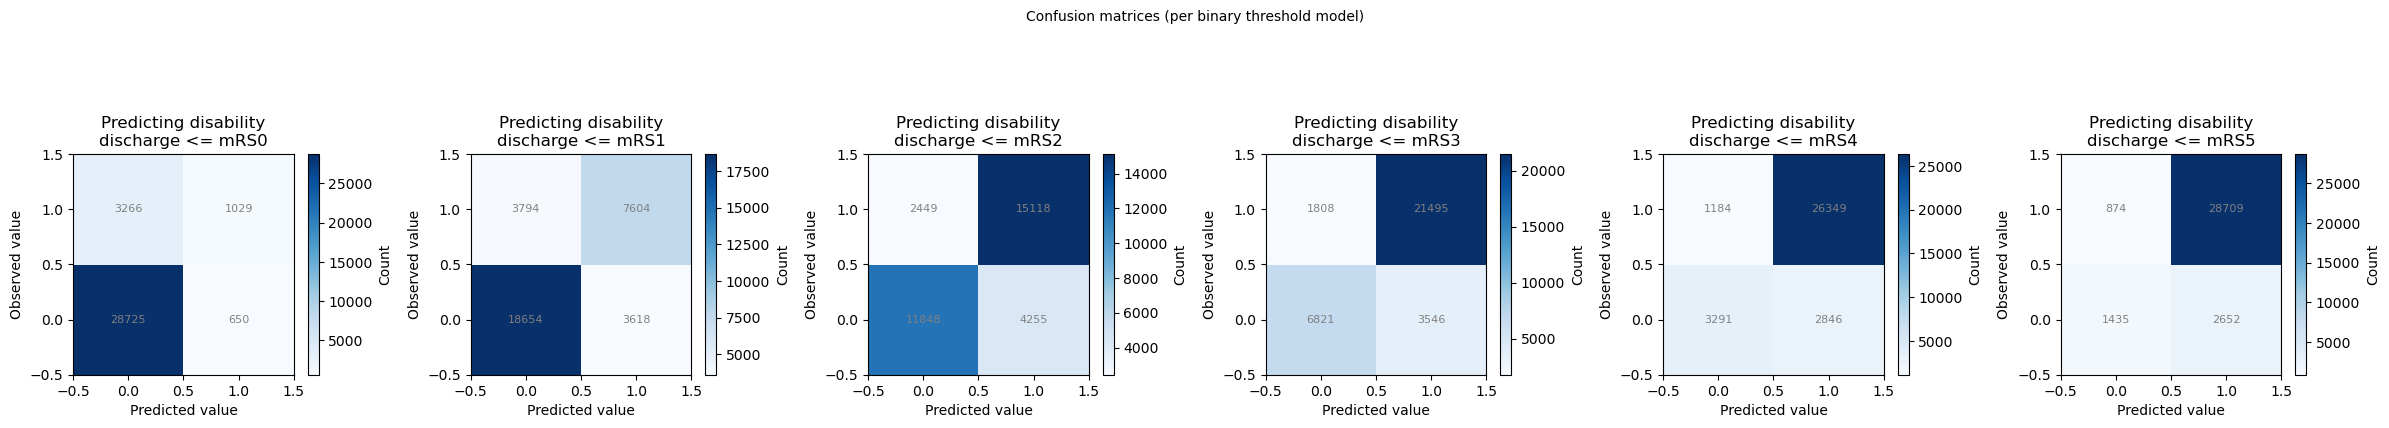

In [21]:
# Define number subplots for the figure
nrows = 1
ncols = n_binary_models

fig, axs = plt.subplots(nrows=nrows, ncols=ncols)

if ncols > 1:
    fig.suptitle('Confusion matrices (per binary threshold model)', fontsize=10)

# Set figure size
fig.set_size_inches(24,5)

# Legend height
shrink = 0.5

# Initialise indices for the subplots
row = 0
col = 0

# Loop through the thresholds, create a confusion matrix per threshold
for binary_threshold, ax in zip(list_binary_thresholds, axs):

    # Set up the target feature name for this threshold
    binary_target_feature_name = f'{target_feature}_bin_{binary_threshold}'

    # Set axis title
    ax.set_title(f'Predicting disability\ndischarge <= mRS{binary_threshold}',
                 fontsize=12)

    # Get y_test binary for this threshold
    y_test_bin = df_all_y_bin_test[binary_target_feature_name]

    # Calculate values for confusion matrix
    cm = confusion_matrix(y_test_bin, y_pred_binary[binary_threshold])

    # Visualize the confusion matrix with colors
    heatmap = ax.imshow(cm, cmap=plt.cm.Blues, origin='lower')
    plt.colorbar(heatmap, shrink=shrink, ax=ax, alpha=0.5, label='Count')

    # Add values to plot
    for i in range(len(cm)):
        for j in range(len(cm[0])):
            ax.text(j, i, cm[i][j], ha='center', va='center', color='grey', 
                    size=8)

    # Set axis titles
    ax.set_xlabel('Predicted value')
    ax.set_ylabel('Observed value')

    # Move to the next subplot
    col += 1

    # Move to the next row if exceed number of columns
    if col == ncols: 
        col = 0
        row += 1

plt.tight_layout()

filename = os.path.join(paths.image_save_path,
                        (paths.notebook + paths.model_text + 
                       '_confusion_matrices_per_binary_threshold.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

For the onwards work in this notebook, let's focus on the model that predicts if a patient is at least as well as mRS2.

In [22]:
# Set threshold to look at
binary_threshold = 2

# Create the target feature name (for this binary case)
binary_target_feature_name = f'{target_feature}_bin_{binary_threshold}'

# Get the y values for hte test set for this threshold
y_test_bin = df_all_y_bin_test[binary_target_feature_name]

# Get the probabilities for each instance for this threshold model
y_probs = y_probs_binary[binary_threshold]

# Get model for specified threshold
model = list_model[binary_threshold]


## Identify intersection of sensitivity and specificity

In [23]:

def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate: Same as specificity
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    false_negatives = (predicted_negatives == 1) & (observed_negatives == 0)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                            (np.sum(true_positives) + np.sum(false_positives)))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                            (np.sum(true_negatives) + np.sum(false_negatives)))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

Calculate data for sensitivity-specificity curve:

In [24]:
# Set up list for accuracy measures
sensitivity = []
specificity = []

# Loop through increments in probability of survival
thresholds = np.arange(0.0, 1.01, 0.01)
for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
    # Get classificiation using cutoff
    predicted_class = y_probs >= cutoff
    predicted_class = predicted_class * 1.0
    # Call accuracy measures function
    accuracy = calculate_accuracy(y_test, predicted_class)
    # Add accuracy scores to lists
    sensitivity.append(accuracy['sensitivity'])
    specificity.append(accuracy['specificity'])

Create a combined plot: ROC and sensitivity-specificity

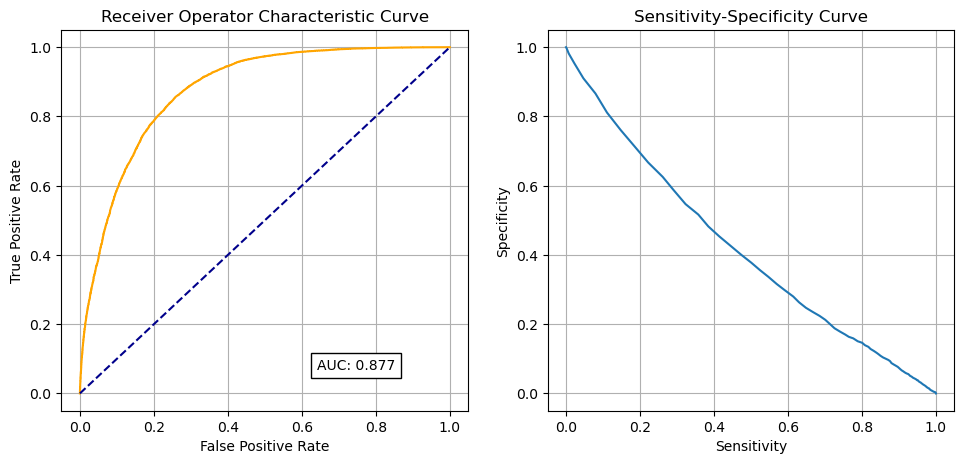

In [25]:
fig = plt.figure(figsize=(10,5))

# Get ROC AUC
fpr, tpr, thresholds = roc_curve(y_test_bin, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC
ax1 = fig.add_subplot(121)
ax1.plot(fpr, tpr, color='orange')
ax1.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('Receiver Operator Characteristic Curve')
text = f'AUC: {roc_auc:.3f}'
ax1.text(0.64,0.07, text, 
         bbox=dict(facecolor='white', edgecolor='black'))
plt.grid(True)

# Plot sensitivity-specificity
ax2 = fig.add_subplot(122)
ax2.plot(sensitivity, specificity)
ax2.set_xlabel('Sensitivity')
ax2.set_ylabel('Specificity')
ax2.set_title('Sensitivity-Specificity Curve')
plt.grid(True)


plt.tight_layout(pad=2)

filename = os.path.join(paths.image_save_path, (paths.notebook + 
                        paths.model_text + '_roc_sens_spec' + '_' + 
                        str(binary_threshold) + '.jpg'))

plt.savefig(filename, dpi=300)

plt.show()

# Identify cross-over point on sensitivity-specificity curve
Adjusting the classification threshold allows us to balance sensitivity (the proportion of patients receiving thrombolysis correctly identified) and specificity (the proportion of patients not receiving thrombolysis correctly identified). An increase in sensitivity causes a loss in specificity (and vice versa). Here we identify the pint where specificity and sensitivity hold the same value.

In [26]:
def get_intersect(a1, a2, b1, b2):
    """ 
    Returns the point of intersection of the lines passing through a2,a1 and 
    b2,b1.
    
    a1: [x, y] a point on the first line
    a2: [x, y] another point on the first line
    b1: [x, y] a point on the second line
    b2: [x, y] another point on the second line
    """
    s = np.vstack([a1,a2,b1,b2])        # s for stacked
    h = np.hstack((s, np.ones((4, 1)))) # h for homogeneous
    l1 = np.cross(h[0], h[1])           # get first line
    l2 = np.cross(h[2], h[3])           # get second line
    x, y, z = np.cross(l1, l2)          # point of intersection
    if z == 0:                          # lines are parallel
        return (float('inf'), float('inf'))
    return (x/z, y/z)

In [27]:
df = pd.DataFrame()
df['sensitivity'] = np.array(sensitivity)
df['specificity'] = np.array(specificity)
df['spec greater sens'] = df['specificity'] > df['sensitivity']

# find last index for senitivity being greater than specificity 
mask = df['spec greater sens'] == False
last_id_sens_greater_spec = np.max(df[mask].index)
locs = [last_id_sens_greater_spec, last_id_sens_greater_spec + 1]
points = df.iloc[locs][['sensitivity', 'specificity']]

# Get intersetction with line of x=y
a1 = list(points.iloc[0].values)
a2 = list(points.iloc[1].values)
b1 = [0, 0]
b2 = [1, 1]

intersection = get_intersect(a1, a2, b1, b2)[0]

print (f'Intersection: {intersection:0.4f}')

Intersection: 0.4350


### SHAP values
SHAP values give the contribution that each feature has on the models prediction, per instance. A SHAP value is returned for each feature, for each instance.

We will use the shap library: https://shap.readthedocs.io/en/latest/index.html

'Raw' SHAP values from XGBoost model are log odds ratios. A SHAP value is returned for each feature, for each instance, for each model (one per k-fold)

### Format the SHAP values data

Features are in the same order in shap_values as they are in the original dataset. Use this fact to extract the SHAP values for the one-hot encoded hospital features.

Create a dataframe containing the SHAP values: an instance per row, and a one-hot encoded hospital feature per column.

In [28]:
def create_df_one_hot_encoded_hosp_features(shap_values_extended, 
                hospital_columns_index, hospital_names):
    """
    Extract the SHAP values for the hospital one hot encoded features.

    Args:
        shap_values_extended [object]: with three parts 
                                      (.values, .basevalues, .data)
        hospital_columns_index [list]: column indices for the one hot encoded
                                       hospital features
        hospital_names [list]: list of the hospital names

    Return:
        df [dataframe]: SHAP values, row per instance, column per hospital one 
                        hot encoded feature
        
    """    


    # Use this index list to access the hosptial shap values (as array)
    hosp_shap_values = shap_values_extended[:,hospital_columns_index].values

    # Put in dataframe with hospital as column title
    df = pd.DataFrame(hosp_shap_values, columns = hospital_names)

    return(df)

In [29]:
def add_columns_to_df(df, stroke_team_values):

    """

    Add these columns:
    # Stroke team instance attended
    # contribution from all the hospital features
    # contribution from attending the hospital
    # contribution from not attending the rest

    Args:
        df []:
        stroke_team_values []:

    Return:
        df [dataframe]:
        
    """  


    # Include Stroke team that each instance attended
    df["Stroke team"] = stroke_team_values

    # Store the sum of the SHAP values (for all of the hospital features)
    df["all_stroke_teams"] = (df.sum(axis=1))

    # Initialise lists for 
    #   1) SHAP value for attended hospital 
    #   2) SHAP value for the sum of the rest of the hospitals
    attended_hospital = []
    not_attend_these_hospitals = []

    # For each patient
    for index, row in df.iterrows():

        # Get stroke team attended
        stroke_team = row["Stroke team"]
        
        # Get SHAP value for the stroke team attended
        attended_hospital.append(row[stroke_team])

        # Calculate sum of SHAP values for the stroke teams not attend 
        sum_rest = row["all_stroke_teams"] - row[stroke_team]
        not_attend_these_hospitals.append(sum_rest)

    # Store two new columns in dataframe
    df["attended_stroke_team"] = attended_hospital
    df["not_attended_stroke_teams"] = (not_attend_these_hospitals)
                    
    # View preview
    return(df)

Get column index of the individual hosptials

In [30]:
# Get list of hospital one hot encoded column titles
hospital_names_ohe = X_test.filter(regex='^team',axis=1).columns
n_hospitals = len(hospital_names_ohe)

# Get list of hospital names without the prefix "team_"
hospital_names = [h[5:] for h in hospital_names_ohe]

# Create list of column index for these hospital column titles
hospital_columns_index = [X_test.columns.get_loc(col) for col in hospital_names_ohe]

# Create dictionary of column index for these hospital column titles
dict_hosp_index={}
for col in hospital_names_ohe:
    dict_hosp_index[f"{col}"] = X_test.columns.get_loc(col)

In [31]:
df_hosp_shap_values = create_df_one_hot_encoded_hosp_features(
                                    list_shap_values_extended[binary_threshold], 
                                    hospital_columns_index, hospital_names)

df_hosp_shap_values = add_columns_to_df(df_hosp_shap_values, test_stroke_team)

View dataframe

In [32]:
df_hosp_shap_values.head()

,Addenbrooke's Hospital,Basildon University Hospital,Blackpool Victoria Hospital,Bradford and Airedale SU,Bronglais Hospital,Broomfield Hospital,Calderdale Royal Hospital,Charing Cross Hospital HASU,Chesterfield Royal,Colchester General Hospital,...,Worcestershire Royal Hospital,Worthing Hospital,Wycombe General Hospital,Yeovil District Hospital,York Hospital,Ysbyty Gwynedd,Stroke team,all_stroke_teams,attended_stroke_team,not_attended_stroke_teams
0,0.0,0.0,-0.003186,0.0,-0.807079,0.0,0.000018,0.0,0.003271,0.00136,...,-0.001685,0.0,-0.002343,0.002397,0.0,0.0,Bronglais Hospital,-0.731576,-0.807079,0.075503
1,0.0,0.0,-0.001668,0.0,0.000000,0.0,0.000618,0.0,0.005828,0.00136,...,-0.002554,0.0,-0.002343,0.004991,0.0,0.0,William Harvey Hospital,1.019652,0.885735,0.133917
2,0.0,0.0,-0.004616,0.0,0.000000,0.0,-0.001800,0.0,0.007818,0.00136,...,-0.001687,0.0,-0.000660,0.007624,0.0,0.0,Prince Charles Hospital,0.360632,0.219955,0.140677
3,0.0,0.0,-0.001761,0.0,0.000000,0.0,0.000618,0.0,0.006615,0.00136,...,-0.001687,0.0,-0.002343,0.011090,0.0,0.0,Cumberland Infirmary,-0.127358,-0.242218,0.114860
4,0.0,0.0,-0.004268,0.0,0.000000,0.0,0.000618,0.0,0.006286,0.00136,...,-0.001687,0.0,-0.002343,0.013656,0.0,0.0,University Hospitals of North Tees and Hartlepool,0.268633,0.146147,0.122486


## Violin plots for SHAP values vs feature values (and a histogram for stroke team feature)

Show the results of a binary model per column.

In [33]:
def set_ax(ax, category_list, feat, rotation=0):
    '''
    ax [matplotlib axis object] = matplotlib axis object
    category_list [list] = used for the xtick labels (the grouping of the data)
    feat [string] = used in the axis label, the feature that is being plotted
    rotation [integer] = xtick label rotation

    reeturn [matplotlib axis object]
    
    resource: 
    https://matplotlib.org/3.1.0/gallery/statistics/customized_violin.html
    '''
    # Set the axes ranges and axes labels
    ax.get_xaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(1, len(category_list) + 1))
    ax.set_xticklabels(category_list, rotation=rotation, fontsize=7)
    ax.set_xlim(0.25, len(category_list) + 0.75)
    ax.set_ylabel(f'SHAP values for {feat}', fontsize=12)
    ax.set_xlabel(f'Feature values for {feat}', fontsize=12)
    return(ax)

In [34]:
def set_each_subplot_same_range_per_row(fig, r, c):
    if c > 1:
        axs = fig.axes
        # Adjust the subplots
        for row in range(r):
            y_min = 999
            y_max = -999  
            # Through each subplot in this row (through columns)
            for col in range(c):
                ax = axs[(row * c) + col]
                y_min = min(y_min,ax.get_ylim()[0])
                y_max = max(y_max,ax.get_ylim()[1])
            for col in range(c):
                ax = axs[(row * c) + col]
                ax.set_ylim(y_min, y_max)

    return(fig)

In [39]:
def violin_plots_compare_models(list_binary_thresholds,
                                list_violin_features, 
                                list_shap_values_extended,
                                equal_steps=True):

    # Feature Age needs special consideration. It needs the x ticks to be created,
    # as the other features with over 50 unique values, but age is already grouped 
    # for the model (into 5yr groups) and so is treated as the other type.

    # figure height depends on number of features, width on number of models
    max_features = len(list_violin_features)
    height = 7 * max_features
    n_models = len(list_binary_thresholds)
    width = 6 * n_models

    # Determine number of rows of subplots by rounding up
    ncols = n_models
    nrows = max_features

    # Create figure
    # "squeeze=False": forces a 2D axs return (even if only one row or column)
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width,height), 
                            squeeze=False)
    fig.suptitle(
            f'Model to predict whether patient is at least as well as each mRS threshold', 
            fontsize=20)

    # A subplot showing violin plot for a feature, from dfferent models.
    # First prepare the fature data for the violin plot: if feature has more than 
    # 50 unique values then assume it needs to be binned (a violin for each bin)

    # Comparing n models (a column of subplots per model)

    for binary_threshold in list_binary_thresholds:
        title = f"Predicting patients at least as well as mRS{binary_threshold}"

        shap_values_extended = list_shap_values_extended[binary_threshold]

        # Through each feature
        for n, feat in enumerate(list_violin_features):   
            #subplot = ((n_models*n)+i)+1
            
            # Get data and SHAP values
            feature_data = shap_values_extended[:, feat].data
            feature_shap = shap_values_extended[:, feat].values

            # If feature has more that 50 unique values, then assume it needs
            #  to be binned (otherwise assume they are unique categories)

            if np.unique(feature_data).shape[0] > 50:
                # bin the data, create a violin per bin
                
                # settings for the plot
                rotation = 45

                if (feat == "onset_to_thrombolysis_time") or (feat == "scan_to_thrombolysis_time"):
                    value_without_negative = np.delete(feature_data, np.where(feature_data == -100))
                    if equal_steps == True:
                        np.min(value_without_negative)
                        np.max(value_without_negative)
                        step = 0.10
                        # Using np.round() and tolist() to force the values to be floats
                        # with 1dp
                        bins = np.round(np.arange(np.min(value_without_negative), 
                                                  np.max(value_without_negative), 
                                                  step * (np.max(value_without_negative) - np.min(value_without_negative))),1)
                    else:
                        # Equal count
                        (res, bins) = pd.qcut(value_without_negative, q=10, retbins=True)

                    bin_list = bins.tolist()
                    # for -100 for no IVT
                    bin_list.insert(0, feature_data.min())
                    n_bins = len(bin_list)-2
                else:

                    step = 30
                    n_bins = min(11, np.int((feature_data.max())/step))
                    
                    # create list of bin values
                    bin_list = [(i*step) for i in range(n_bins)]
                    bin_list.append(feature_data.max())

                # Number of instances per bin
                counts, edges = np.histogram(feature_data, bins=bin_list, density=False)

                # create list of bins (the unique categories)
                category_list = [f'{int(bin_list[i+1])}-{int(bin_list[i+2])}\n[n={int(counts[i+1])}]' for i in range(n_bins-1)]
                category_list.append(f'{int(bin_list[-2])}+\n[n={int(counts[-1])}]')
                if (feat == "onset_to_thrombolysis_time") or (feat == "scan_to_thrombolysis_time"):
                    # for -100 for no IVT
                    category_list.insert(0, f'Not receive IVT\n[n={int(counts[0])}]')

                # bin the feature data
                feature_data = pd.cut(feature_data, bin_list, labels=category_list, 
                                      right=False)

                # create a list, each entry contains the corresponsing SHAP value for that 
                # category (or bin). A violin will represent each list.    
                shap_per_category = []
                for category in category_list:
                    mask = feature_data == category
                    shap_per_category.append(feature_shap[mask])

            else:
                # create a violin per unique value
                
                # settings for the plot
                rotation = 90
                
                # create list of unique categories in the feature data
                category_list = np.unique(feature_data)

                # Age needs to keep its decimal value (midpoint between 5 yrs)
                if feat != 'age':
                    # category_list = [int(i) for i in category_list]
                    # Account for nan in the NIHSS features (ignore and include them)
                    category_list = [int(i) if not np.isnan(i) else i for i in category_list]
                    # Account for nan in the NIHSS features (ignore and exclude them)
                    # category_list = [int(i) for i in category_list if not np.isnan(i)]
                    
                # create a list, each entry contains the corresponsing SHAP value for that 
                # category (or bin). A violin will represent each list.    
                count = []
                shap_per_category = []
                for category in category_list:
                    mask = feature_data == category
                    shap_per_category.append(feature_shap[mask])
                    count.append(mask.sum())
    #                if feat == 'stroke_severity':
    #                    print(feature_shap[mask].max())

                if feat == 'age':
                    # create text of x ticks
                    category_list = [f'{int(i-2.5)}-{int(i+2.5)}' for 
                                                        i in category_list]

                    # SSNAP dataset had oldest age category as 100-120 (not a 5 yr band as 
                    #   the other ages). To accommodate this, if last age category is "110"
                    #   then overwrite the label with the correct band (100-120), and not
                    #   107-112 as the above code would create.
                    if category_list[-1] == '107-112':
                        category_list[-1] = '100-120'
                if feat == 'stroke_severity':
                    # not enough space of chart for 2 lines fo x tick labels
                    category_list = [f'{category_list[i]} [n={count[i]}]' for 
                                                i in range(len(category_list))]
                else:
                    category_list = [f'{category_list[i]}\n[n={count[i]}]' for 
                                                i in range(len(category_list))]

            # create violin plot
            ax = axs[n][binary_threshold]
            nans = [float('nan'), float('nan')]
            # For the case where there is an empty array for a violin
            ax.violinplot([val if val.any() else nans for val in shap_per_category],
                           showmeans=True, widths=0.9)

            # Add line at Shap = 0
            feature_values = shap_values_extended[:, feat].data
            ax.plot([0, len(feature_values)], [0,0],c='0.5')   

            # customise the axes
            ax = set_ax(ax, category_list, feat, rotation=rotation)
            plt.subplots_adjust(bottom=0.15, wspace=0.05)

            # Adjust stroke severity tickmarks
            if feat == 'Stroke severity':
                ax.set_xticks(np.arange(1, len(category_list)+1, 2))
                ax.set_xticklabels(category_list[0::2])   
                
            # Add title
            ax.set_title(f'{title} \n Feature: {feat}')

    # Subplots on same row have same y range
    fig = set_each_subplot_same_range_per_row(fig, nrows, ncols)

    space_for_suptitle = 1 - (max_features * 0.005/5)
    plt.tight_layout(pad=2, rect=[0, 0, 1, space_for_suptitle])
    
    filename = os.path.join(paths.image_save_path, (paths.notebook + 
                            paths.model_text + '_shap_violin.jpg'))
    
    fig.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)

    plt.show()
    return()

In [40]:
def histograms_compare_models(list_binary_thresholds,
                              list_unique_stroketeams,
                              list_shap_values_extended):#,
#                              list_title):

    dp = 3
    # figure height depends on number of features, width on number of models
    n_models = len(list_binary_thresholds)
    width = 5.8 * n_models

    nrows = 1
    ncols = n_models
    # Create figure
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(width,6.5), 
                            constrained_layout=True)

    fig.suptitle(
            f'Model to predict whether patient is at least as well as each mRS threshold', 
            fontsize=20)

    # histogram for stroke team SHAP for an output category, comparing models

    # First prepare the feature data

    # Comparing n models (a column of subplots per model)
    for binary_threshold in list_binary_thresholds:

        title = f"Predicting patients at least as well as mRS{binary_threshold}"        
        
        shap_values_extended = list_shap_values_extended[binary_threshold]

        # Get mean SHAP for stroke team when patient attending that stroke team
        stroke_team_mean_shap = []

        # If there are stroke teams
        if len(list_unique_stroketeams) > 0:
            # Loop through feature names
            for feature_name in list_unique_stroketeams:
                # Use the data column for team name as a mask for patients that attend the team (the data will be the same for all class_categories)
                mask = shap_values_extended[:, feature_name].data == 1
                # Use make to get the SHAP values for the stroke team, for the patients that attend this team
                stroke_team_shap = shap_values_extended[:, feature_name].values[mask]
                # Get mean
                mean_shap = np.mean(stroke_team_shap)
                # Store mean
                stroke_team_mean_shap.append(mean_shap)
            if n_models == 1:
                ax = axs                
            else:
                ax = axs[binary_threshold]

            ax.hist(stroke_team_mean_shap, 
                    color=[0.12156863, 0.46666667, 0.70588235, 0.3], 
                    ec=[0.12156863, 0.46666667, 0.70588235, 1.], 
                    linewidth=1.4)#, bins=np.arange(-1.5, 1.5, 0.1)

            ax.set_xlabel('SHAP values for hospital attended')
            ax.set_ylabel('Count')

            
        #    plt.tight_layout(pad=2, rect=[0, 0, 1, space_for_suptitle])

            # Add title
            ax.set_title(f'{title} \n Feature: stroke team')


            text =('\n'.join((
                f'Mean: {round(np.mean(stroke_team_mean_shap),dp)}',
                f'Standard deviation '
                f'{round(np.std(stroke_team_mean_shap),dp)}')))

            # place a text box in upper left in axes coords
            props = dict(boxstyle='round', facecolor='grey', alpha=0.2)
            ax.text(0, (-0.15), text, 
                    transform=ax.transAxes, fontsize=10, 
                    verticalalignment='top', bbox=props)


    # Subplots on same row have same y range
    fig = set_each_subplot_same_range_per_row(fig, nrows, ncols)

    
    filename = os.path.join(paths.image_save_path, (paths.notebook + 
                            paths.model_text + '_hosp_shap_hist.jpg'))
    
    plt.savefig(filename, dpi=300, bbox_inches='tight', pad_inches=0.2)
    plt.show()

    range_shap_log_odds = max(stroke_team_mean_shap) - min(stroke_team_mean_shap)
    odds = math.exp(range_shap_log_odds)
    print(f"There was a {round(odds,2)} fold difference in odds of being "
          f"classified as mRS{binary_threshold} between hospitals")
    
    return()

In [41]:
# Create a mask for feature names that don't contain string "team_"
mask_exclude_team = ['team_' not in i for i in feature_names_ohe]
mask_include_team = ['team_' in i for i in feature_names_ohe]

# Use mask to exclude features containing string "team_"
model_features = np.array(feature_names_ohe)
model_features_wo_teams = model_features[mask_exclude_team]
model_team_features = model_features[mask_include_team]

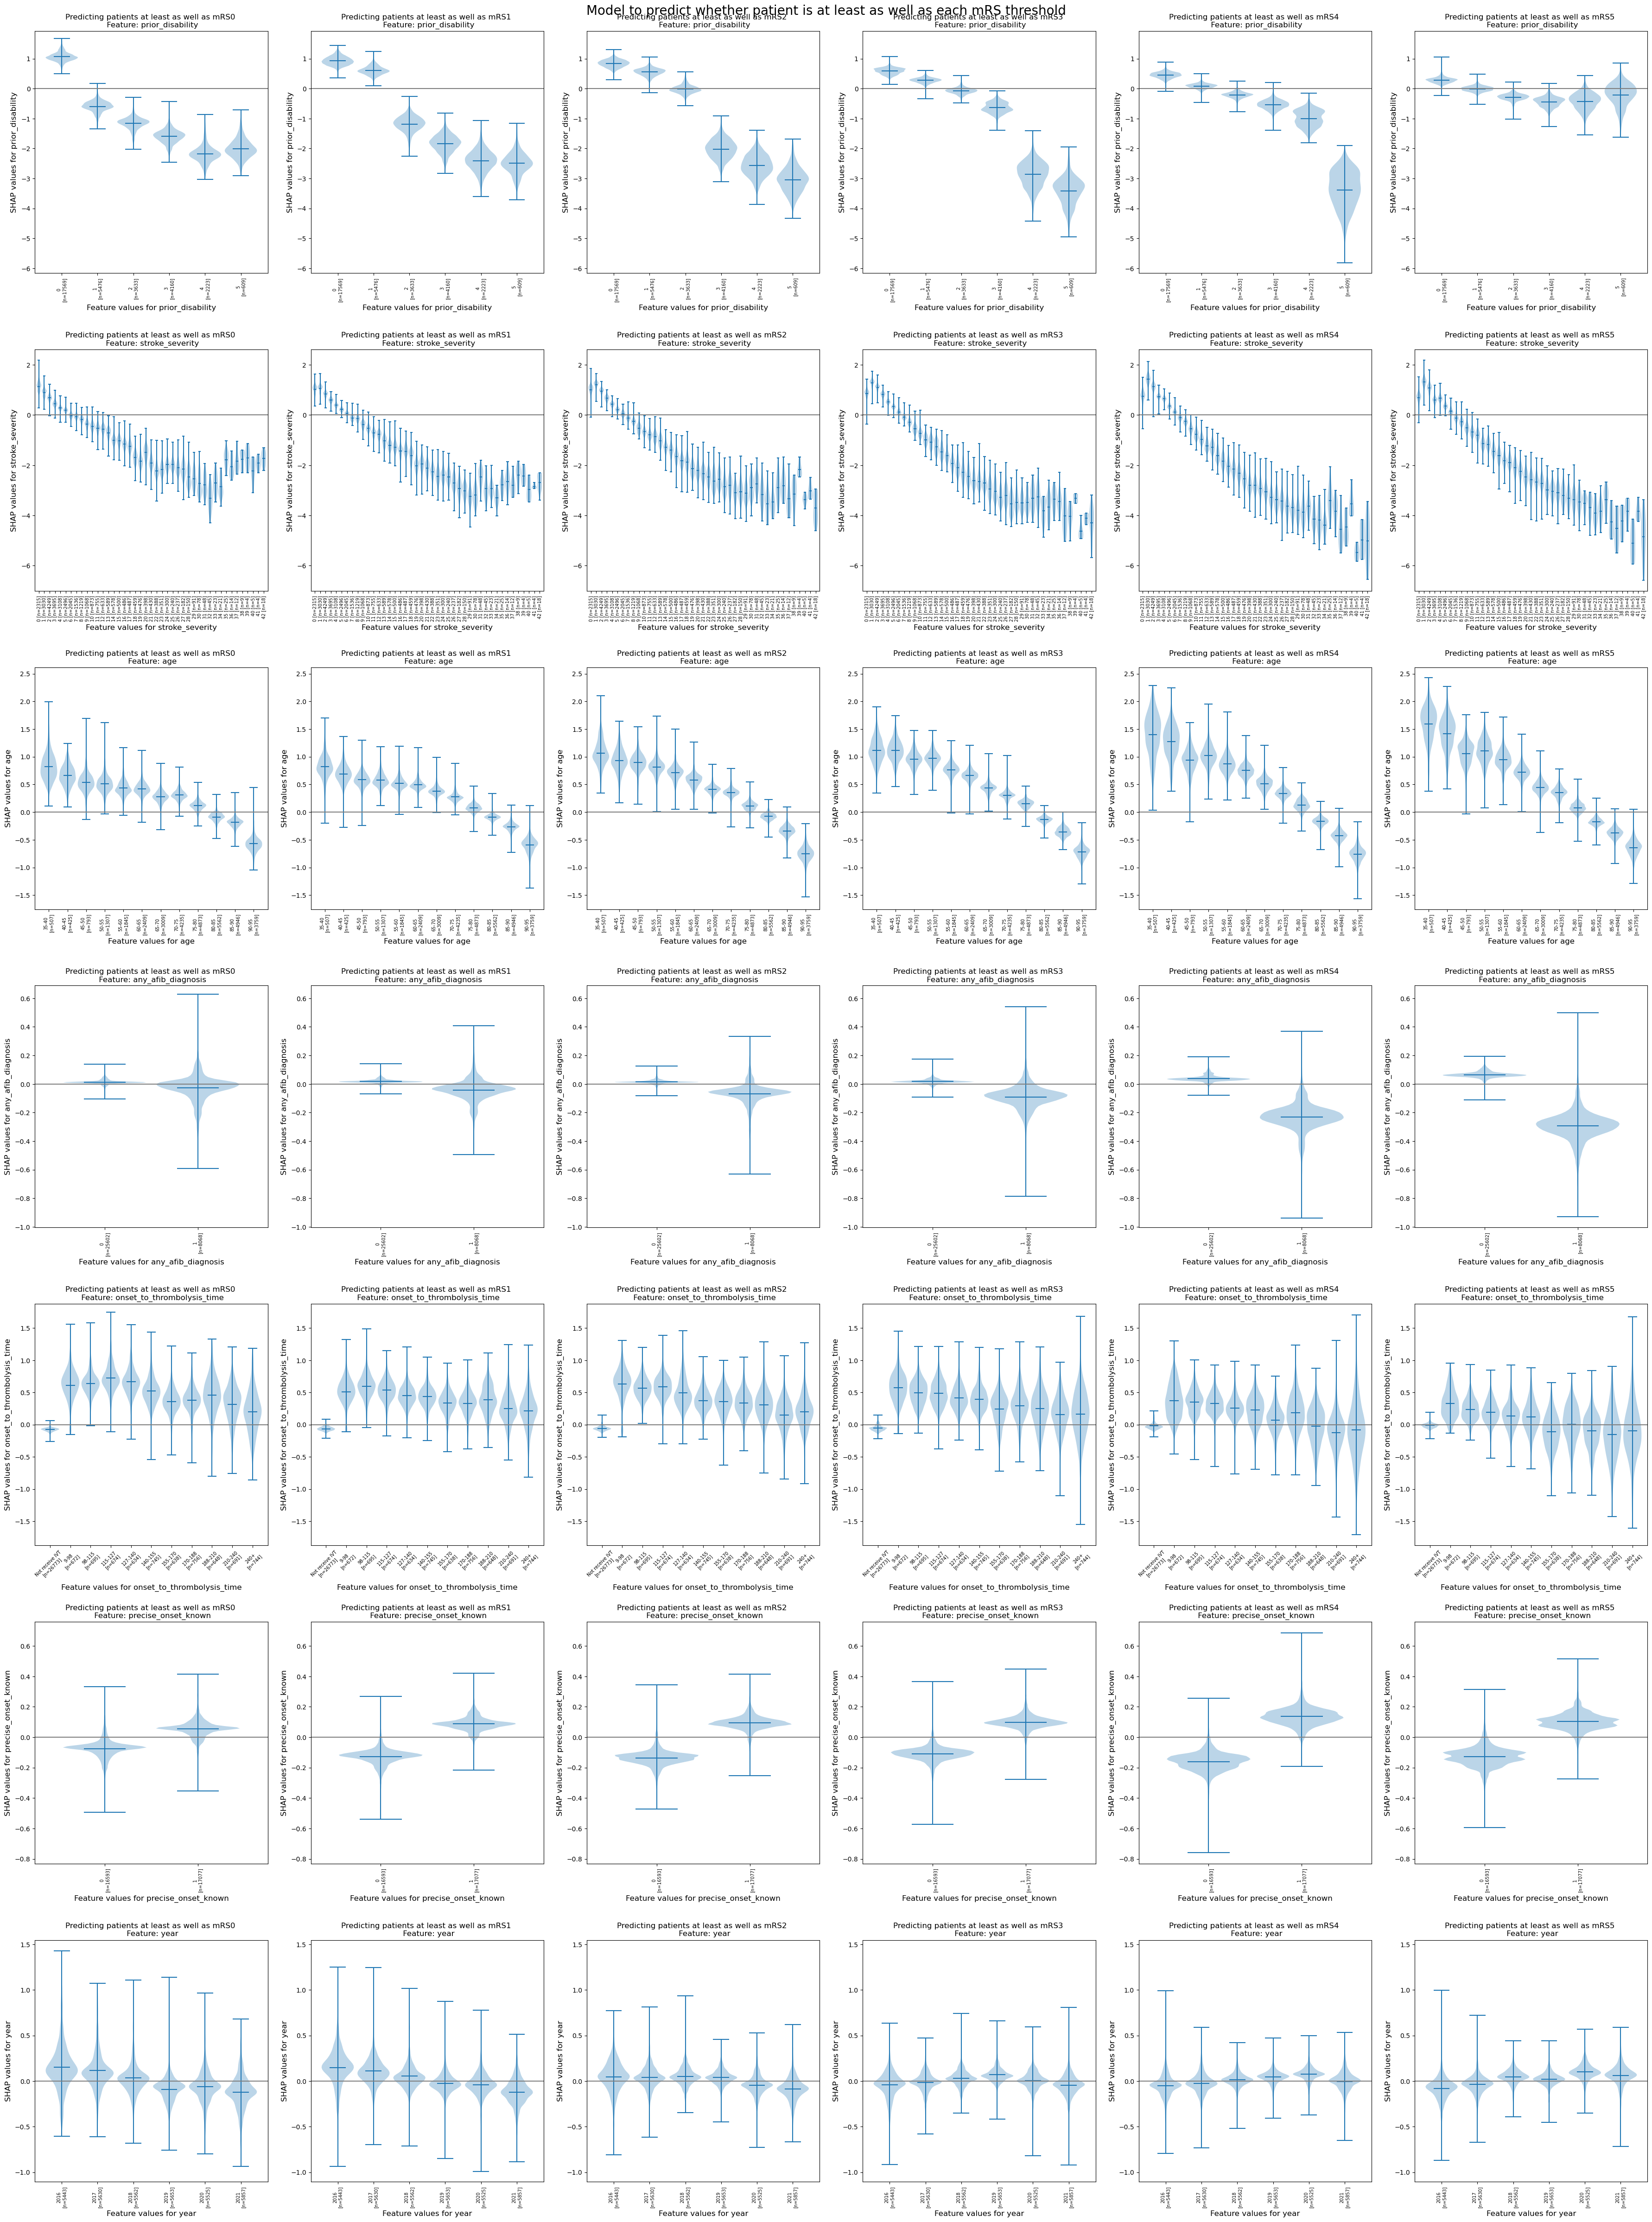

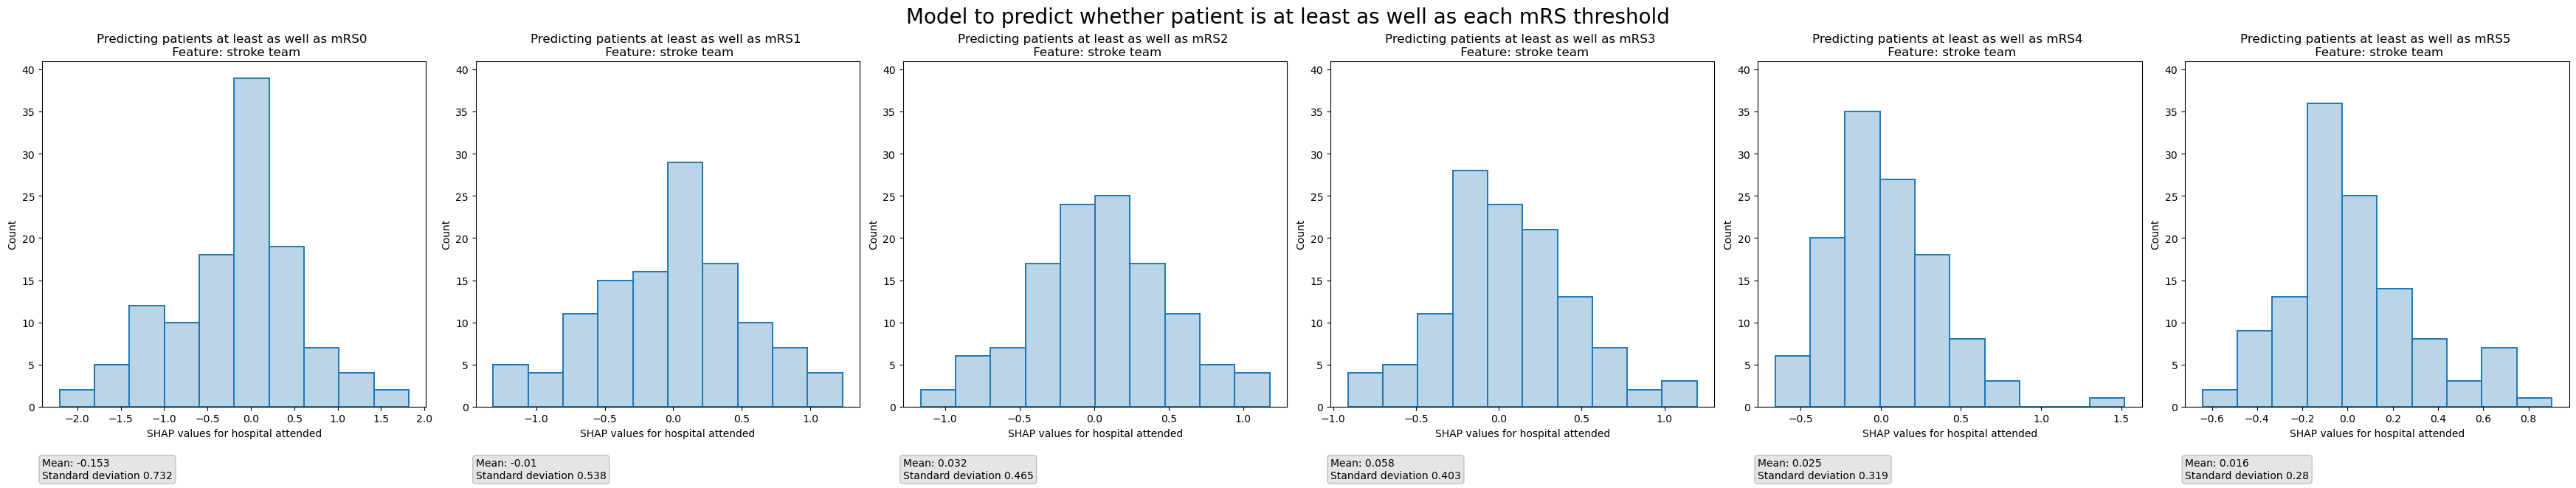

There was a 4.68 fold difference in odds of being classified as mRS5 between hospitals


()

In [42]:
# Violin plots of feature data vs SHAP values
violin_plots_compare_models(list_binary_thresholds,
                            model_features_wo_teams.tolist(),
                            list_shap_values_extended,
                            equal_steps=False)

# Histogram of stroke team SHAP values
histograms_compare_models(list_binary_thresholds,
                          model_team_features.tolist(),
                          list_shap_values_extended)